# Analysis of neuron_labeling dataset from scNT-seq

## Load packages

In [1]:
import pandas as pd
import dynamo as dyn

In [2]:
from dynamo_pp_workflow import dynamo_pp_workflow

In [3]:
import storm

##  Load data

In [4]:
filename = './data/neuron_labeling.h5ad'
neuron_labeling = dyn.read_h5ad(filename)

In [5]:
neuron_labeling.obs['label_time'] = 2  # this is the labeling time
tkey = 'label_time'

In [6]:
# need gene list
peng_gene_list = pd.read_csv('./data/0408_grp_info.txt', sep='\t')
neuron_labeling = neuron_labeling[:, peng_gene_list.index]

In [7]:
neuron_labeling.obs['time'] = neuron_labeling.obs.time.astype('category')

/tmp/ipykernel_4288/3224617247.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  neuron_labeling.obs['time'] = neuron_labeling.obs.time.astype('category')


##  Preprocess data using Dynamo package

In [8]:
dynamo_pp_workflow(neuron_labeling, tkey=tkey, experiment_type='one-shot', n_top_genes=1000)

|-----> Running monocle preprocessing pipeline...
|-----------> filtered out 0 outlier cells
|-----------> filtered out 0 outlier genes


/home/pqw/anaconda3/envs/dynamo_storm/lib/python3.8/site-packages/dynamo/preprocessing/normalization.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  szfactors = adata.obs[total_szfactor][:, None]


|-----> PCA dimension reduction
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> computing cell phase...
|-----? 
Dynamo is not able to perform cell cycle staging for you automatically. 
Since dyn.pl.phase_diagram in dynamo by default colors cells by its cell-cycle stage, 
you need to set color argument accordingly if confronting errors related to this.
|-----> [Preprocessor-monocle] completed [0.2296s]
|-----> calculating first/second moments...
|-----> [moments calculation] completed [10.6405s]


## Run Storm's parameter inference and RNA velocity estimation methods

In [9]:
storm.storm_one_shot_data(adata=neuron_labeling, use_genes=neuron_labeling.var_names[neuron_labeling.var.use_for_pca],
                     assumption='steady_state', method='CSP_Baseline', tkey=tkey)

Estimate gamma via linear regression of t vs. -ln(1-K): 0it [00:00, ?it/s]/home/pqw/anaconda3/envs/dynamo_storm/lib/python3.8/site-packages/dynamo/estimation/csc/utils_velocity.py:251: RuntimeWarning: invalid value encountered in scalar divide
  r2, all_r2 = 1 - SS_res_n / SS_tot_n, 1 - all_SS_res_n / all_SS_tot_n
Estimate gamma via linear regression of t vs. -ln(1-K): 97it [00:00, 1093.51it/s]
Infer parameters via maximum likelihood estimation based on the CSP model under the steady-state assumption: 97it [00:00, 1839.06it/s]
/home/pqw/pythonProject/storm.py:286: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  k = 1 - np.exp(-gamma[:, None] * time[None, :])
/home/pqw/pythonProject/storm.py:291: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

## Visualize RNA velocity results using Dynamo package

In [10]:
neuron_labeling.uns["dynamics"] = {"has_splicing" : False, "has_labeling" : True}

In [11]:
def streamline(adata):
    dyn.tl.reduceDimension(adata, reduction_method='umap')
    dyn.tl.cell_velocities(adata, enforce=True, vkey='velocity_T', ekey='M_t', basis='umap',
                          transition_genes=adata.var_names[adata.var.select_genes])
    dyn.pl.streamline_plot(adata, color=['time'], basis='umap')
    return adata

|-----> retrieve data for non-linear dimension reduction...
|-----> [UMAP] using X_pca with n_pca_components = 30
|-----> <insert> X_umap to obsm in AnnData Object.
|-----> [UMAP] completed [11.4042s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [1.5082s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding]

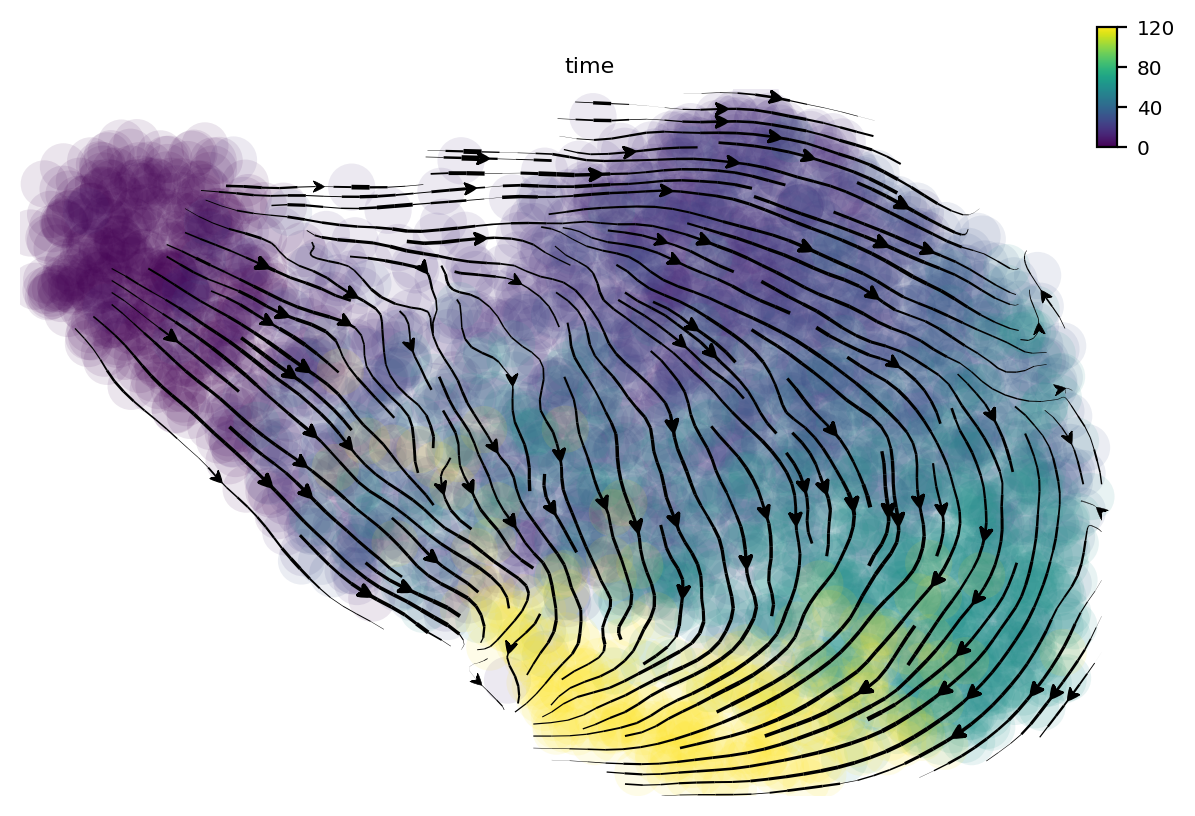

AnnData object with n_obs × n_vars = 3060 × 97
    obs: 'cell_type', '4sU', 'treatment', 'time', 'cell_name', 'label_time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'total_Size_Factor', 'initial_total_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr'
    var: 'gene_short_name', 'activity_genes', 'nCells', 'nCounts', 'pass_basic_filter', 'frac', 'use_for_pca', 'ntr', 'gamma', 'gamma_r2', 'alpha', 'select_genes', 'use_for_transition'
    uns: 'pp', 'feature_selection', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'dynamics', 'neighbors', 'umap_fit', 'grid_velocity_umap'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    layers: 'new', 'total', 'X_total', 'X_new', 'M_t', 'M_tt', 'M_n', 'M_tn', 'M_nn', 'M_CSP_t', 'M_CSP_n', 'velocity_T', 'cell_wise_alpha'
    obsp: 'moments_con', 'distances', 'connectivities', 'pearson_transition_matrix'

In [12]:
streamline(adata=neuron_labeling)